In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

clients = pd.read_csv('../data/Clients.csv', delimiter=';', encoding='latin1')
commandes = pd.read_csv('../data/Commandes.csv', delimiter=';', encoding='latin1')
envois_chunks = pd.read_csv('../data/Envois.csv', delimiter=';', encoding='latin1', chunksize=500000)
envois = envois_chunks.get_chunk()
produits = pd.read_csv('../data/Produits.csv', delimiter=';', encoding='latin1')

IndexError: index 2 is out of bounds for axis 0 with size 2

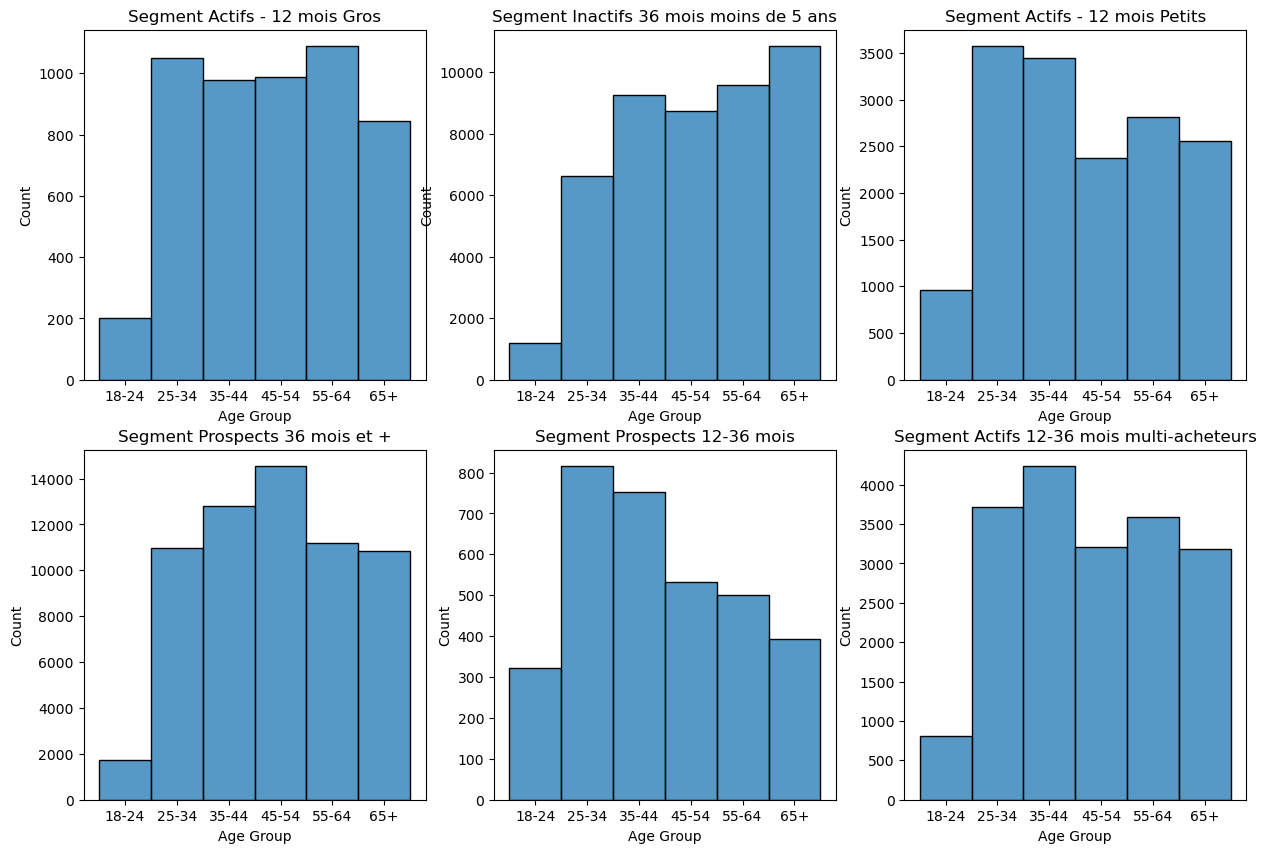

In [2]:
# Create age groups
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
clients['Age Group'] = pd.cut(clients['Age'], bins=bins, labels=labels, include_lowest=True)

# Create histograms of client segmentation
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for i, segment in enumerate(clients['Segmentation'].unique()):
    sns.histplot(data=clients[clients['Segmentation'] == segment], x='Age Group', ax=axs[i//3, i%3], kde=False)
    axs[i//3, i%3].set_title(f'Segment {segment}')
    axs[i//3, i%3].set_xlabel('Age Group')
    axs[i//3, i%3].set_ylabel('Count')
plt.tight_layout()
plt.show()

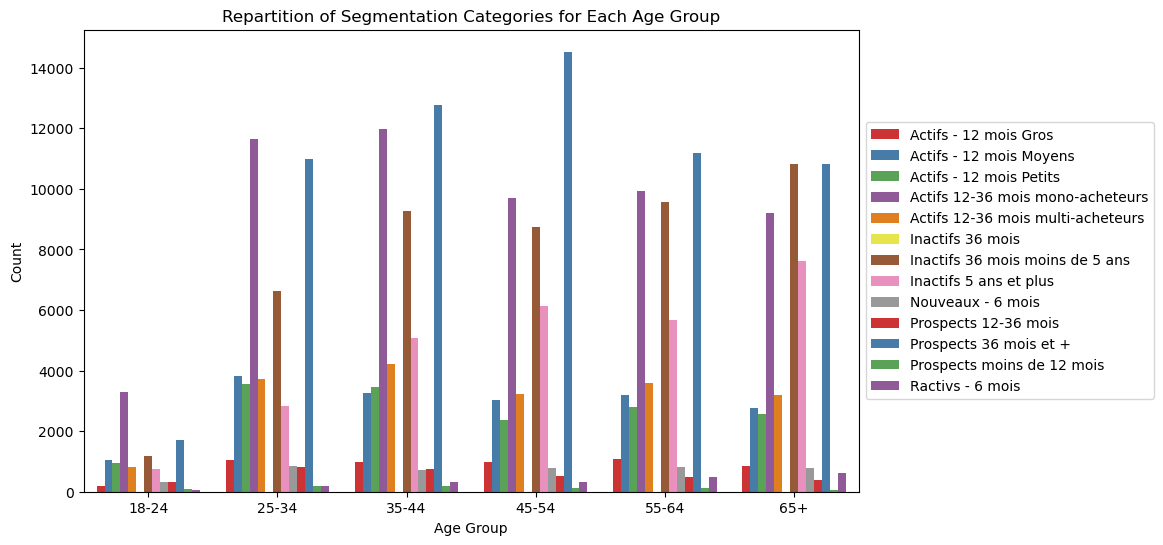

In [3]:
# Count the number of clients in each age group and segmentation category
age_segment_counts = clients.groupby(['Age Group', 'Segmentation']).size().reset_index(name='Count')

# Create a unique plot for the distribution of segmentation categories for each age group
plt.figure(figsize=(10, 6))
sns.barplot(data=age_segment_counts, x='Age Group', y='Count', hue='Segmentation', palette='Set1')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Repartition of Segmentation Categories for Each Age Group')
plt.show()

In [4]:
# Create a new column to calculate the total amount spent per command
commandes['Montant_Produit'] = commandes['Montant_Produit'].astype(str).str.replace(',', '.').astype(float)
commandes['Montant_Remise'] = commandes['Montant_Remise'].astype(str).str.replace(',', '.').astype(float)
commandes['Montant_depense'] = commandes['quantite_produit'] * (commandes['Montant_Produit'] - commandes['Montant_Remise'])

# merge clients & commandes
merged_clients_comm = pd.merge(clients, commandes, on='id_client', how='inner')

# merge commandes & produits
merged_comm_prod = pd.merge(commandes, produits, on='id_produit', how='inner')

# merge all three tables
merged_clients_comm_prod = pd.merge(merged_clients_comm, produits, on='id_produit', how='inner')

Produit A    198262
Produit B    133663
Produit C     48217
Produit D     44720
Name: Categorie_Produit, dtype: int64


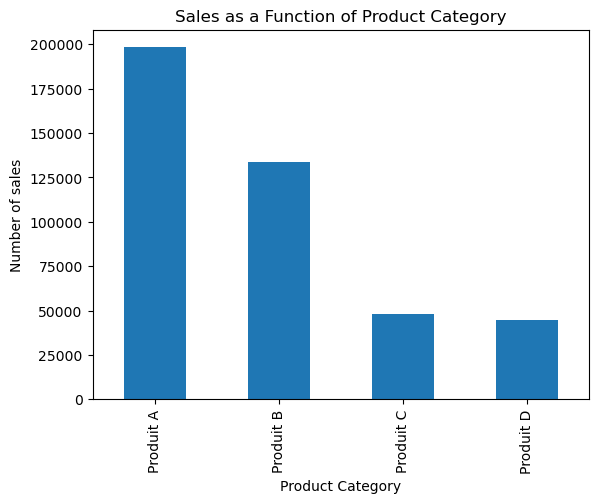

In [5]:
# Get the number of occurrences of each product type
product_counts = merged_clients_comm_prod['Categorie_Produit'].value_counts()

print(product_counts)
product_counts.plot(kind='bar')
plt.xlabel('Product Category')
plt.ylabel('Number of sales')
plt.title('Sales as a Function of Product Category')
plt.show()


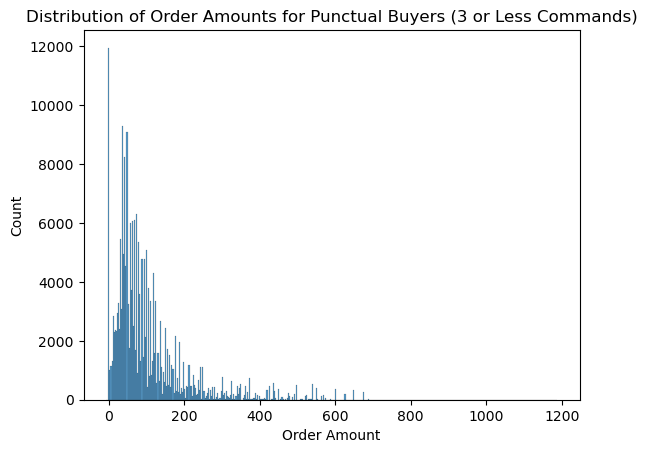

103.08081428445776


In [6]:
# Filter the data to only include punctual buyers who have made 3 or less commands
punctual_buyers = merged_clients_comm_prod.groupby('id_client').filter(lambda x: len(x) <= 3)

# Plot the distribution of order amounts for punctual buyers
sns.histplot(data=punctual_buyers, x='Montant_depense', kde=False)
plt.xlabel('Order Amount')
plt.ylabel('Count')
plt.title('Distribution of Order Amounts for Punctual Buyers (3 or Less Commands)')
plt.show()

mean_punctual = punctual_buyers['Montant_depense'].mean()
print(mean_punctual)

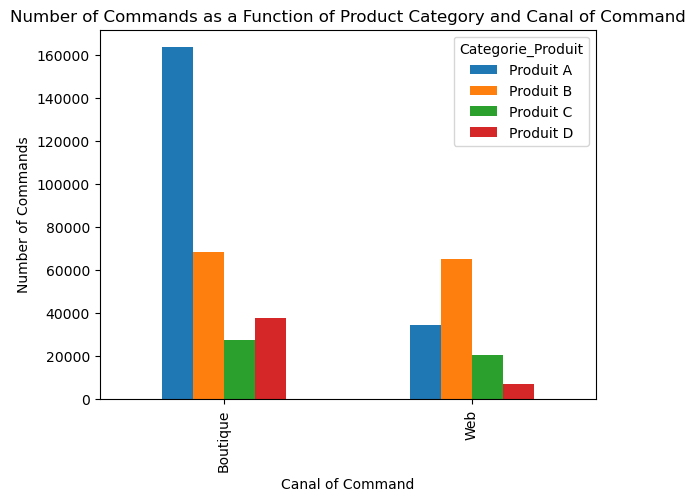

In [7]:
# Create a pivot table with the number of commands for each product category and canal of command
command_counts = merged_comm_prod.pivot_table(index='Canal_Commande', columns='Categorie_Produit', values='id_commande', aggfunc='count')

# Create a bar plot of the pivot table
command_counts.plot(kind='bar')
plt.xlabel('Canal of Command')
plt.ylabel('Number of Commands')
plt.title('Number of Commands as a Function of Product Category and Canal of Command')
plt.show()


In [8]:
# Calculate mean amount spent per client as a function of age group
mean_amounts = merged_clients_comm_prod.groupby('Age Group')['Montant_depense'].mean()

# Plot the mean amount spent per client as a function of age group
"""plt.plot(mean_amounts.index, mean_amounts.values)
plt.xlabel('Age Group')
plt.ylabel('Mean Amount Spent per Client')
plt.title('Mean Amount Spent per Client as a Function of Age Group')
plt.show()"""
print(mean_amounts)

Age Group
18-24    95.911367
25-34    89.561486
35-44    83.756333
45-54    93.676586
55-64    91.229330
65+      92.487875
Name: Montant_depense, dtype: float64
